# Notebook for testing the algorithms under Google colab

## 1. Introduction
The algorithms are defined in the publication:
    Javier Sánchez, The Inverse Compositional Algorithm for Parametric Registration, Image Processing On Line, 6 (2016), pp. 212–232. https://doi.org/10.5201/ipol.2016.153

The algorithms are implemented in Python as a result of a translation from the original C++ code released by the author.
The repository used here contains a dataset with images and the ground truth transformations to test the algorithms, as the ones available in the online demo on IPOL: https://ipolcore.ipol.im/demo/clientApp/demo.html?id=153
This enable users of this notebook to check easily the validity of the python implementation.

## 2.Test of algorithms

In [1]:
import matplotlib.pyplot as plt
import imageio
import os
import sys
import skimage as ski
import time

print(os.getcwd())
sys.path.append(os.path.abspath("../src/"))
from inverse_compositional_algorithm import inverse_compositional_algorithm, robust_inverse_compositional_algorithm, pyramidal_inverse_compositional_algorithm
import configuration_handler as cfh
import image_optimisation as io

/mnt/git/computational_astro/inverse_compositional_algorithm/test


### Preparation of the configuration file

We create a configuration file with the meta parameters for the algorithm. 

In [2]:
# cfh.create_config_file("config.ini")
# reading the parameters from the configuration file
params = cfh.read_config_file("config.ini")
params_ica = params["inverse_compositional_algorithm"]
params_rica = params["robust_inverse_compositional_algorithm"]
params_pica = params["pyramidal_inverse_compositional_algorithm"]

# define a dict with image filename and transformation ground truth

# calling the pipeline
# output_img, debug_dict = process(pic_root, options, params)


### Preparation of the dataset

In [3]:
import transformation as tf
import numpy as np
import os.path as path

In [4]:
# A dataset with simple transformations for unit testing
dataset_tu = {
    "rubber_whale_tr": {
        "filename": "rubber_whale.png",
        "transformation_type": tf.TransformType.TRANSLATION,
        "gt": [10, 5] # [tx,ty]
    },
    "rubber_whale_rt": {
        "filename": "rubber_whale.png",
        "transformation_type": tf.TransformType.EUCLIDEAN,
        "gt": [0., 0., -0.1] # [tx,ty,theta] -> ROTATION, theta in radians and counterclockwise
    },
    "rubber_whale_eu": {
        "filename": "rubber_whale.png",
        "transformation_type": tf.TransformType.EUCLIDEAN,
        "gt": [10., 5., -0.1] # [tx,ty,theta] -> ROTATION, theta in radians and counterclockwise
    },
    "rubber_whale_zo": {
        "filename": "rubber_whale.png",
        "transformation_type": tf.TransformType.SIMILARITY,
        "gt": [0., 0., -0.1, 0.] # [tx,ty,a,b] -> ZOOM
    }
}

In [5]:
print("The current directory is: ", os.getcwd())
image_path = os.path.join(os.getcwd(), "data")

The current directory is:  /mnt/git/computational_astro/inverse_compositional_algorithm/test


Dataset image:  rubber_whale_tr
	Filename:  rubber_whale.png
Image type:  float64
Range of image:  0.0 255.0
Saving transformed image to file rubber_whale_tr.png in directory /mnt/git/computational_astro/inverse_compositional_algorithm/test/data


/tmp/ipykernel_3905343/130964960.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  original_image = imageio.imread(path.join(image_path, sample["filename"]))


Image type:  float64
Range of image:  0.0 255.0
Dataset image:  rubber_whale_rt
	Filename:  rubber_whale.png
Image type:  float64
Range of image:  0.0 255.0
Saving transformed image to file rubber_whale_rt.png in directory /mnt/git/computational_astro/inverse_compositional_algorithm/test/data


/tmp/ipykernel_3905343/130964960.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  original_image = imageio.imread(path.join(image_path, sample["filename"]))


Image type:  float64
Range of image:  0.0 255.0
Dataset image:  rubber_whale_eu
	Filename:  rubber_whale.png
Image type:  float64
Range of image:  0.0 255.0
Saving transformed image to file rubber_whale_eu.png in directory /mnt/git/computational_astro/inverse_compositional_algorithm/test/data
Image type:  float64
Range of image:  0.0 255.0
Dataset image:  rubber_whale_zo
	Filename:  rubber_whale.png
Image type:  float64
Range of image:  0.0 255.0
Saving transformed image to file rubber_whale_zo.png in directory /mnt/git/computational_astro/inverse_compositional_algorithm/test/data
Image type:  float64
Range of image:  0.0 255.0


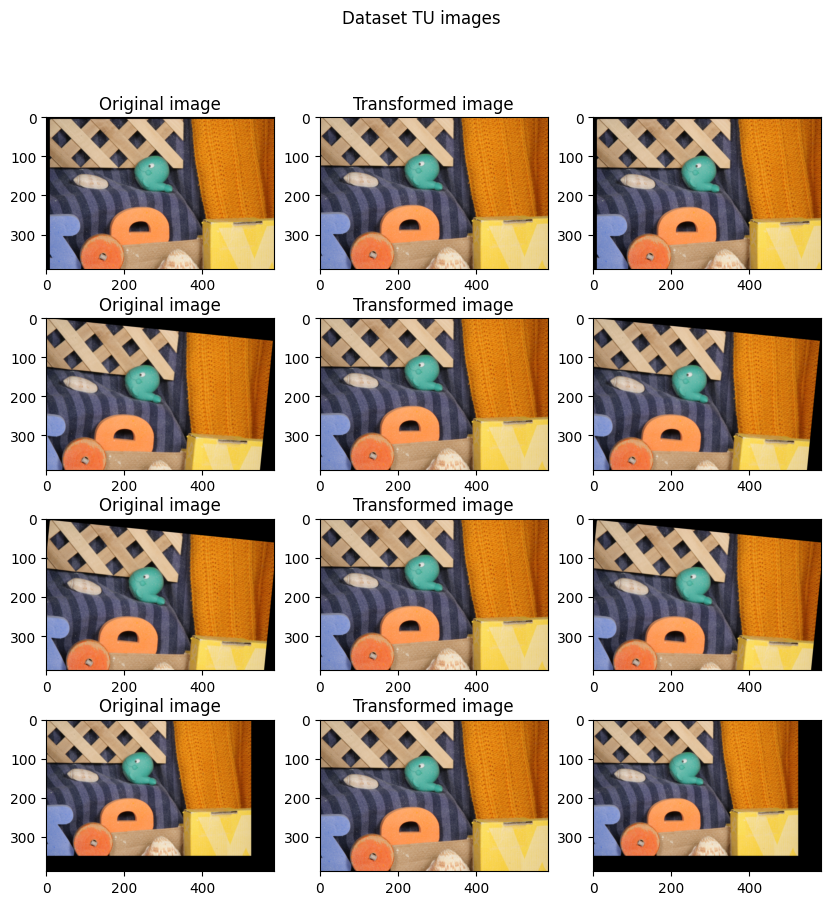

In [6]:
# transform the images and show them
fig, axs = plt.subplots(4, 3, figsize=(10,10))
fig.suptitle("Dataset TU images")
i = 0
for sample_key, sample in dataset_tu.items():
    print("Dataset image: ", sample_key)
    print("\tFilename: ", sample["filename"])
    original_image = imageio.imread(path.join(image_path, sample["filename"]))
    sample["original_image"] = original_image
    transformation_type = sample["transformation_type"]
    gt = sample["gt"]
    # we transform the source image to the target image according to the ground truth
    transformed_image = tf.transform_image(original_image, transformation_type, gt)
    ofilename = sample_key + ".png"
    print("Saving transformed image to file {} in directory {}".format(ofilename, image_path))
    imageio.imwrite(
            path.join(image_path, ofilename), 
            ski.img_as_ubyte(ski.exposure.rescale_intensity(transformed_image))
            )
    # print("\tType of transformed image: ", transformed_image.dtype)
    # To avoid too many errors with image black borders, we swith the reference image to the transformed image
    sample["original_image"] = transformed_image
    sample["transformed_image"] = original_image
    # In that case, the gt transform from transformed to original is the inverse of the gt
    gti=tf.matrix2params(np.linalg.inv(tf.params2matrix(gt, transformation_type)), transformation_type)
    sample["gt"] = gti
    # display the image
    axs[i][0].imshow(ski.exposure.rescale_intensity(sample["original_image"]))
    axs[i][0].set_title("Original image")
    # axs[i][1].imshow(source_image)
    # axs[i][1].set_title("Source image")
    axs[i][1].imshow(ski.exposure.rescale_intensity(sample["transformed_image"]))
    axs[i][1].set_title("Transformed image")
    Iw = tf.transform_image(sample["transformed_image"], transformation_type, gt)
    axs[i][2].imshow(ski.exposure.rescale_intensity(Iw))
    i += 1

plt.show()

**Update**:
The authors of the original software and of the online demo, provide the gt transformation from the source image to the transformed image. But the source image is already transformed compared to the original image. I have not been able to recover the transformation from the original to the source and from the source to the transformed.

So for my test, I will use the original image as the source, transformed with the given gt given in the online demo. Inputs are then different from the online demo, but the matter is to verify the correctness of the gt computation.

### Test of the algorithm "Inverse compositional"

------ Inverse Compositional Algorithm for a translation ------
Processing dataset image:  rubber_whale_tr
With Meta parameters:  {'TOL': 0.001, 'transform_type': <TransformType.EUCLIDEAN: 2>, 'verbose': False}
For transformation type:  TransformType.TRANSLATION
Ix.shape (388, 584, 3)
Iy.shape (388, 584, 3)
J.shape (388, 584, 4)
DIJ.shape (388, 584, 3, 2)
DIJ reshaped:  (226592, 6)
valid mask:  (226592, 6)
valid DIJ:  (622656, 2)
hessian shape:  (2, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


DIJ_masked shape:  (388, 584, 3, 2)
DI_masked shape:  (388, 584, 3)
DIJ_masked.T shape:  (2, 3, 584, 388)
Iteration 0: |Dp|=nan: p=(nan nan)
Elapsed time:  82.16708087921143
Original parameters:  [-10.0, -5.0]
Estimated parameters:  [nan nan]
Error on estimati  nan


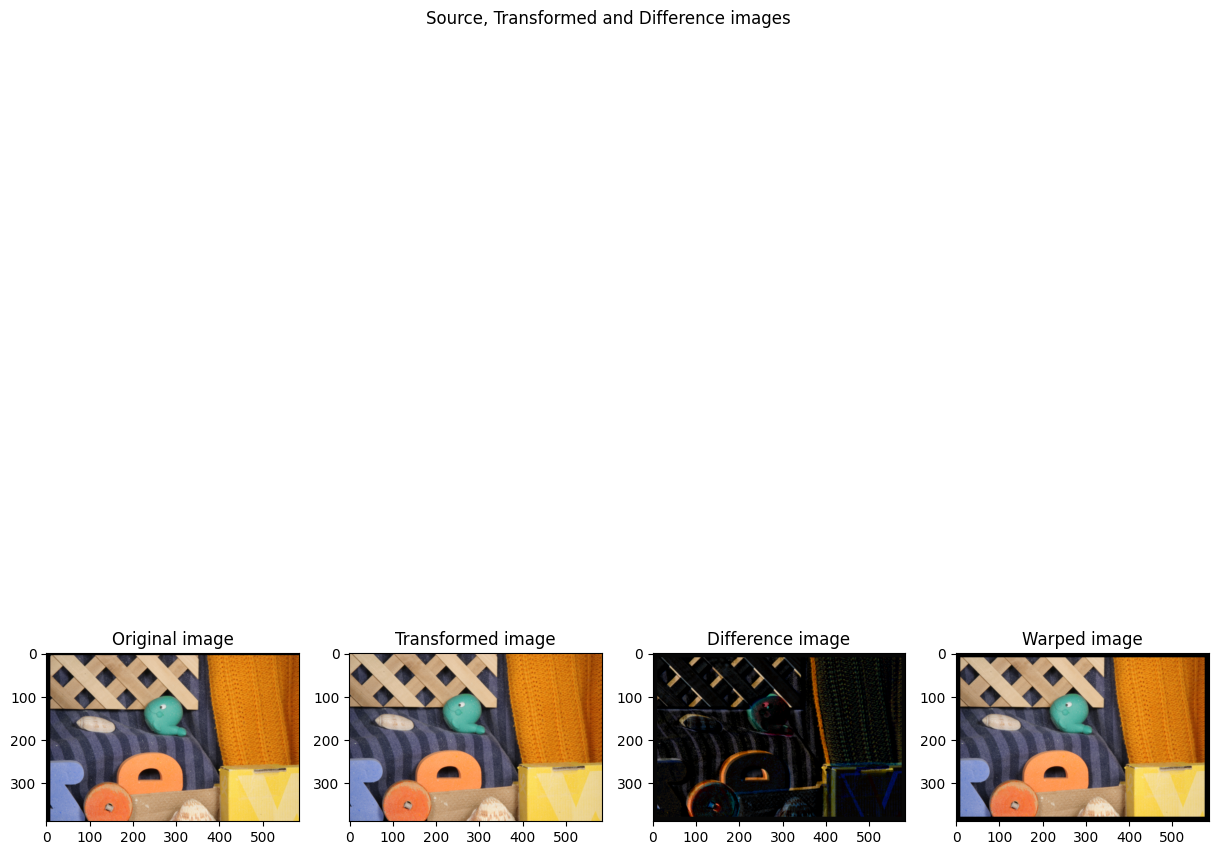

In [7]:
print("------ Inverse Compositional Algorithm for a translation ------")
fig, axs = plt.subplots(1, 4, figsize=(15,15))
fig.suptitle("Source, Transformed and Difference images")
i = 0
sample = dataset_tu["rubber_whale_tr"]
sample_key = "rubber_whale_tr"
    
print("Processing dataset image: ", sample_key)
original_image = sample["original_image"]
transformation_type = sample["transformation_type"]
p = np.zeros(transformation_type.nparams())
gt = sample["gt"]
# we generate the source image according to the ground truth
# source_image = generate_source_image(original_image, transformation_type, gt)
# we transform the source image to the target image according to the ground truth
transformed_image = sample["transformed_image"]
# p, error, DI, Iw = inverse_compositional_algorithm(
#             original_image, transformed_image, p, transformation_type, params_ica["TOL"], params_ica["verbose"]
#         )
print("With Meta parameters: ", params_ica)
print("For transformation type: ", transformation_type)
start = time.time()
p, error, DI, Iw = inverse_compositional_algorithm(
                original_image,
                transformed_image,
                p,
                transformation_type, 
                True, 10, 
                params_ica["TOL"], 
                verbose=True)
end = time.time()
print("Elapsed time: ", end-start)
# p, error, DI, Iw = pyramidal_inverse_compositional_algorithm(
#     original_image,
#     transformed_image,
#     p,
#     transformation_type, 
#     params_pica["pyramid_levels"], 
#     params_pica["nu"],
#     params_pica["TOL"],
#     io.RobustErrorFunctionType.QUADRATIC, 
#     0,  
#     params_pica["verbose"]
# )
# display the image
axs[0].imshow(ski.exposure.rescale_intensity(original_image))
axs[0].set_title("Original image")
# axs[i][1].imshow(source_image)
# axs[i][1].set_title("Source image")
axs[1].imshow(ski.exposure.rescale_intensity(transformed_image))
axs[1].set_title("Transformed image")
# img = axs[i][2].imshow(DI, cmap="gray", vmin=0, vmax=np.max(np.max(DI)))
# fig.colorbar(img, ax=axs[i][2])
axs[2].imshow(ski.exposure.rescale_intensity(np.nan_to_num(DI, copy=True)))
axs[2].set_title("Difference image")
axs[3].imshow(ski.exposure.rescale_intensity(np.nan_to_num(Iw, copy=True)))
axs[3].set_title("Warped image")

print("Original parameters: ", gt)
print("Estimated parameters: ", p)
print("Error on estimati ", error)
plt.show()

In [ ]:
print("------ Inverse Compositional Algorithm for a rotation ------")
fig, axs = plt.subplots(1, 4, figsize=(15,15))
fig.suptitle("Source, Transformed and Difference images for a rotation")
i = 0
sample = dataset_tu["rubber_whale_rt"]
sample_key = "rubber_whale_rt"
    
print("Processing dataset image: ", sample_key)
original_image = sample["original_image"]
transformation_type = sample["transformation_type"]
p = np.zeros(transformation_type.nparams())
gt = sample["gt"]
# we generate the source image according to the ground truth
# source_image = generate_source_image(original_image, transformation_type, gt)
# we transform the source image to the target image according to the ground truth
transformed_image = sample["transformed_image"]
# p, error, DI, Iw = inverse_compositional_algorithm(
#             original_image, transformed_image, p, transformation_type, params_ica["TOL"], params_ica["verbose"]
#         )
print("With Meta parameters: ", params_ica)
print("For transformation type: ", transformation_type)
p, error, DI, Iw = inverse_compositional_algorithm(
                original_image,
                transformed_image,
                p,
                transformation_type, 
                True, 10, 
                params_ica["TOL"], 
                True)
# p, error, DI, Iw = pyramidal_inverse_compositional_algorithm(
#     original_image,
#     transformed_image,
#     p,
#     transformation_type, 
#     params_pica["pyramid_levels"], 
#     params_pica["nu"],
#     params_pica["TOL"],
#     io.RobustErrorFunctionType.QUADRATIC, 
#     0,  
#     params_pica["verbose"]
# )
# display the image
axs[0].imshow(ski.exposure.rescale_intensity(original_image))
axs[0].set_title("Original image")
# axs[i][1].imshow(source_image)
# axs[i][1].set_title("Source image")
axs[1].imshow(ski.exposure.rescale_intensity(transformed_image))
axs[1].set_title("Transformed image")
# img = axs[i][2].imshow(DI, cmap="gray", vmin=0, vmax=np.max(np.max(DI)))
# fig.colorbar(img, ax=axs[i][2])
axs[2].imshow(ski.exposure.rescale_intensity(np.nan_to_num(DI, copy=True)))
axs[2].set_title("Difference image")
axs[3].imshow(ski.exposure.rescale_intensity(np.nan_to_num(Iw, copy=True)))
axs[3].set_title("Warped image")

print("Original parameters: ", gt)
print("Estimated parameters: ", p)
print("Error on estimati ", error)
plt.show()

In [ ]:
# print("------ Inverse Compositional Algorithm on dataset_tu ------")
# fig, axs = plt.subplots(5, 4, figsize=(15,15))
# fig.suptitle("Source, Transformed and Difference images")
# i = 0
# for sample_key, sample in dataset_tu.items():
#     print("Processing dataset image: ", sample_key)
#     original_image = sample["original_image"]
#     transformation_type = sample["transformation_type"]
#     p = np.zeros(transformation_type.nparams())
#     gt = sample["gt"]
#     # we generate the source image according to the ground truth
#     # source_image = generate_source_image(original_image, transformation_type, gt)
#     # we transform the source image to the target image according to the ground truth
#     transformed_image = sample["transformed_image"]
#     # p, error, DI, Iw = inverse_compositional_algorithm(
#     #             original_image, transformed_image, p, transformation_type, params_ica["TOL"], params_ica["verbose"]
#     #         )
#     print("With Meta parameters: ", params_pica)
#     print("For transformation type: ", transformation_type)
#     p, error, DI, Iw = pyramidal_inverse_compositional_algorithm(
#         original_image,
#         transformed_image,
#         p,
#         transformation_type, 
#         params_pica["pyramid_levels"], 
#         params_pica["nu"],
#         params_pica["TOL"],
#         io.RobustErrorFunctionType.QUADRATIC, 
#         0,  
#         params_pica["verbose"]
#     )
#     # display the image
#     axs[i][0].imshow(ski.exposure.rescale_intensity(original_image))
#     axs[i][0].set_title("Original image")
#     # axs[i][1].imshow(source_image)
#     # axs[i][1].set_title("Source image")
#     axs[i][1].imshow(ski.exposure.rescale_intensity(transformed_image))
#     axs[i][1].set_title("Transformed image")
#     # img = axs[i][2].imshow(DI, cmap="gray", vmin=0, vmax=np.max(np.max(DI)))
#     # fig.colorbar(img, ax=axs[i][2])
#     axs[i][2].imshow(ski.exposure.rescale_intensity(DI))
#     axs[i][2].set_title("Difference image")
#     axs[i][3].imshow(ski.exposure.rescale_intensity(Iw))
#     axs[i][3].set_title("Warped image")
#     i += 1
#     print("Original parameters: ", gt)
#     print("Estimated parameters: ", p)
#     print("Error on estimation: ", error)

# plt.show()
